In [1]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-1 # 1e-6

# learning rate
LR = 4e-3
DEVICE = 'cuda'


In [2]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [3]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [4]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [5]:
# import time
# import collections

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
# import torch.nn.functional as F

# import openmm as omm
from openmm import app, unit


### import the coarse-graining module
import coarsegrainer as cg
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer, AnnealingLR
from coarsegrainer.energy import Energy, EnergyModule, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

### protein folding module
import proteinfolding as pf

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

# Loading protein

In [6]:
# pdb_id = '2WXC' # '2JOF' # '5AWL'
pdb_id = '2JOF'

pdb_dir = '../data/pdb/'
os.makedirs(pdb_dir, exist_ok=True) 

pdb_file = os.path.join(pdb_dir, pdb_id+'.pdb')

# check if pdb file exists, if not download it
if not os.path.isfile(pdb_file):
    pdb_file = pf.download_pdb_file(pdb_id, dir = pdb_dir)
    
prot = pf.Protein(pdb_file)


In [7]:
pf.pdb_3d_view(pdb_file, width=400, height=300)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
pdb = app.PDBFile(pdb_file)
modeller = app.Modeller(pdb.topology, pdb.positions)
forcefield = app.ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
#self.modeller.deleteWater()
# modeller.addSolvent(forcefield, model="tip3p", padding=.05 * unit.nanometer)
system = forcefield.createSystem(modeller.topology)#, nonbondedMethod=PME, constraints=HBonds)


In [9]:
system.getNumParticles(), system.getNumForces()

(284, 5)

In [10]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = prot.node_positions.detach().numpy()*10 # 10x to go from nm to angstrom

pdb_orig_file = os.path.join(pdb_dir, f'orig-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_orig_file , 'w'))

pf.pdb_3d_view(pdb_orig_file, width=400, height=300)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
# p_.addModel(pf.get_file_text(pdb_file), 'pdb')
# p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'


# Unfolding protein

In [10]:
unfolder = pf.ProteinFolderOMM(pdb_file, temperature=1000)

In [11]:
pos = unfolder.run(10)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-26986.716970518,976.963581964513
2000,-25790.325505330926,963.288126967301
Epoch 1/10, Energy: 876.38, Time: 0.24 s
3000,-26095.004518583184,1022.7389747262185
4000,-26481.774721219903,986.5625321097091
Epoch 2/10, Energy: 829.24, Time: 0.21 s
5000,-25603.107067182427,988.5148506251916
6000,-25862.608757093316,1017.4711307671384
Epoch 3/10, Energy: 2304.05, Time: 0.21 s
7000,-26183.031501844293,990.0561178612414
8000,-25650.870298459893,994.3730422464945
Epoch 4/10, Energy: 1876.36, Time: 0.21 s
9000,-25541.44851119793,1014.8253707828641
10000,-25541.38847930706,992.7814250958163
Epoch 5/10, Energy: 1941.78, Time: 0.22 s
11000,-26156.116406515008,980.5485189445546
12000,-25820.682769849664,1036.2584305807115
Epoch 6/10, Energy: 2866.06, Time: 0.21 s
13000,-25519.37704761303,1020.9225298744605
14000,-26477.114712312585,1003.3560593840505
Epoch 7/10, Energy: 1298.79, Time: 0.21 s
15000,-25720.267963483697,976.2325119607775
1600

In [12]:
unfolder.pdb_file

'../data/pdb/2JOF.pdb'

In [13]:
pdb_unfolded = unfolder.save_pdb()

Saving pdb file to ../data/pdb/fold_2JOF-T1000-steps20000.pdb


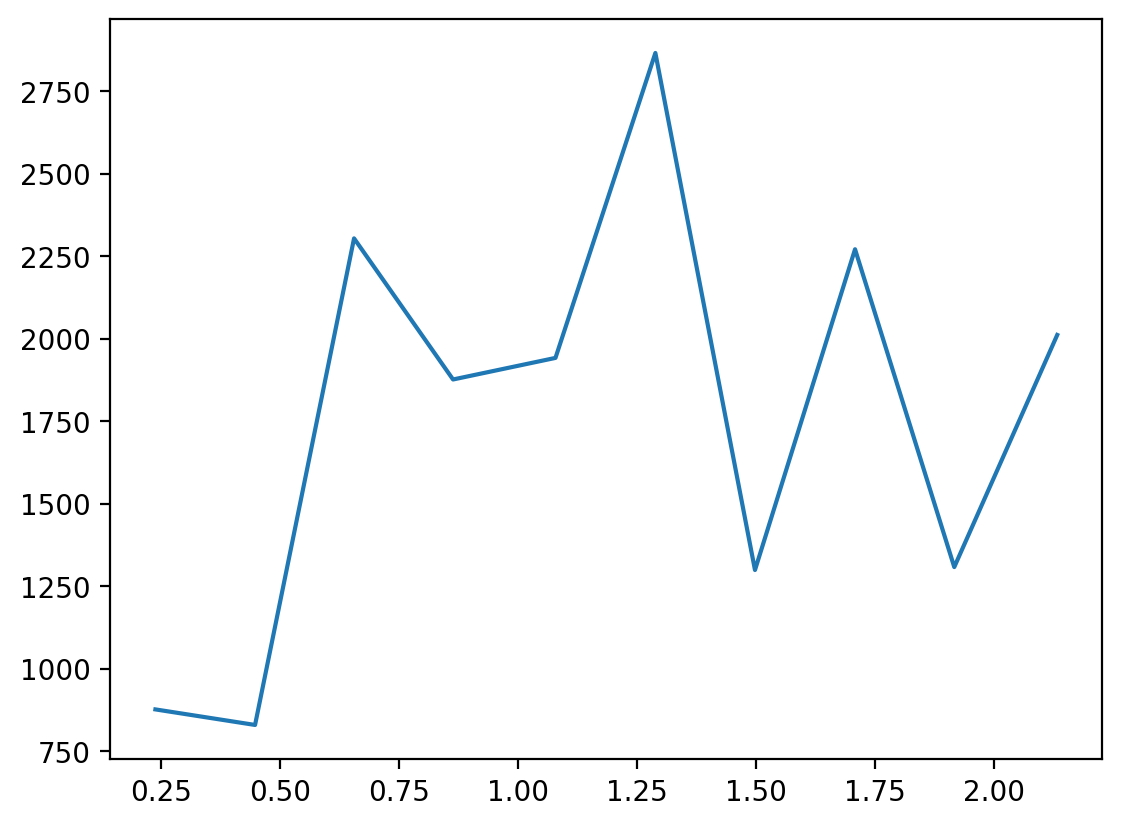

In [14]:
# plot energy vs time from history of the simulation
plt.plot(np.cumsum(unfolder.history['time']), unfolder.history['total_energy'])

In [17]:
pf.pdb_3d_view(pdb_unfolded)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [29]:
rmsd = pf.RMSD(pdb_orig_file, pdb_unfolded)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 5.0942136877802415, 'CA': 3.425703938272908, 'backbone': 3.229776275043227}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [18]:
refolder = pf.ProteinFolderOMM(pdb_unfolded, temperature=298)

In [19]:
pos = refolder.run(10)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-71833.19428076397,384.30444467963713
2000,-78401.44616522442,331.56442795445486
Epoch 1/10, Energy: -63830.49, Time: 0.82 s
3000,-80315.45424093853,303.0588223056079
4000,-81330.7563230003,297.90720469775164
Epoch 2/10, Energy: -68238.90, Time: 0.20 s
5000,-81731.24916662823,300.6819979510335
6000,-82011.81218542706,295.0244156520149
Epoch 3/10, Energy: -69046.64, Time: 0.20 s
7000,-81606.14964880596,302.7846113000822
8000,-81675.5061856712,300.4381852005773
Epoch 4/10, Energy: -68472.42, Time: 0.20 s
9000,-82081.0868283714,294.49654045781807
10000,-81826.45182623516,299.2950959878565
Epoch 5/10, Energy: -68673.60, Time: 0.21 s
11000,-81653.41462530743,299.36682613850763
12000,-81433.36781897198,300.62162848446485
Epoch 6/10, Energy: -68222.23, Time: 0.20 s
13000,-81152.61678137432,294.5271568172628
14000,-81565.47109808575,301.98317354413854
Epoch 7/10, Energy: -68294.49, Time: 0.20 s
15000,-81430.59270300518,295.39570015070

In [20]:
refolder.pdb_file

'../data/pdb/fold_2JOF-T1000-steps20000.pdb'

In [21]:
pdb_refolded = refolder.save_pdb()

Saving pdb file to ../data/pdb/fold_fold_2JOF-T1000-steps20000-T298-steps20000.pdb


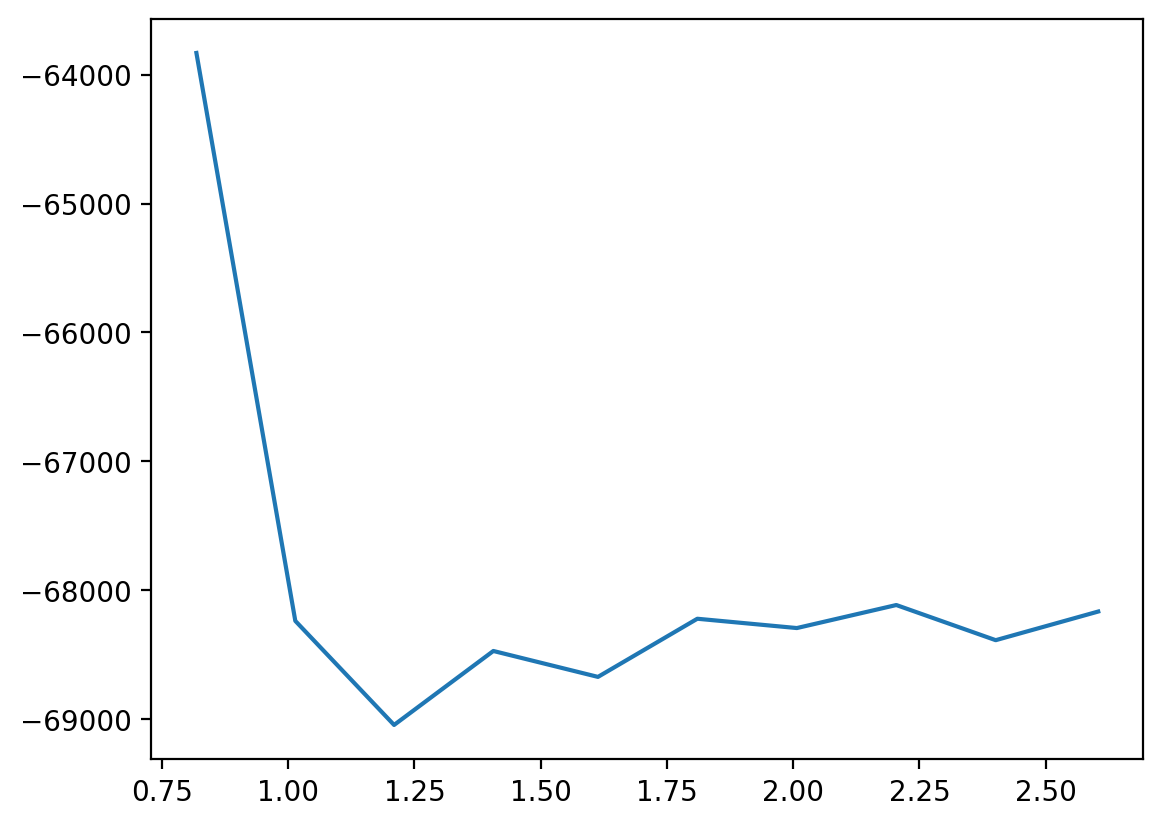

In [22]:
# plot energy vs time from history of the simulation
plt.plot(np.cumsum(refolder.history['time']), refolder.history['total_energy'])

In [23]:
pf.pdb_3d_view(pdb_refolded)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [30]:
rmsd = pf.RMSD(pdb_orig_file, pdb_refolded)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 5.531916148470496, 'CA': 4.07073217951377, 'backbone': 3.8533055845203577}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Energy Minimization

In [69]:
p = positions[0]

In [85]:
pos_unfold = np.array([[i.x,i.y,i.z] for i in  positions.value_in_unit(unit.nanometer)])
pos_unfold = torch.tensor(pos_unfold, dtype=torch.float32)


In [10]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
# unfolded energy
pdb_unfolded_energy = energy(pos_unfold.to(DEVICE)).item()

f"{pdb_energy:.4g}, {pdb_unfolded_energy:.4g}"
# f"{pdb_energy:.4g}"

## Starting from unfolded PDB positions

In [213]:
# define the initial position
# initial_pos = x = prot.node_positions.to(DEVICE)
initial_pos = x = pos_unfold.to(DEVICE)

energy_minimizer = EnergyMinimizer(energy, initial_pos, optimizer_type='Adam', lr=LR, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='protein_', patience=PATIENCE, min_delta=MIN_DELTA)

Using Adam optimizer
Log name: protein_
Logging to: ../results/logs/protein__n284_d3


In [214]:
# h = energy_minimizer.train(10000)

In [ ]:
relax_counter = 3
for epoch in range(100):
    h = energy_minimizer.train(500)
    # also print the current lr
    if np.isnan(h['energy'][-1]):
        print('============Fail! nan')
        break
    c = energy_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end='\r')
    # annealer.step()
    # print(f'FG lr: {annealer.get_last_lr()[0]:.2e}', end = '\r')

    if energy_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 400 time: 39.98 s, pat:17,
epoch: 1, energy: 84763, time: 40.77 s, pat:20,
relaxing 2
Early stopping at step 460 time: 44.56 s, pat:12,
epoch: 6, energy: 84750.9, time: 45.47 s, pat:20,
relaxing 1
Early stopping at step 440, time: 52.12 s, pat:16,
epoch: 14, energy: 84752, time: 52.99 s, pat:20,
relaxing 0
Early stopping at step 400
epoch: 15, energy: 84754.6, time: 53.77 s, pat:20,
relaxing -1


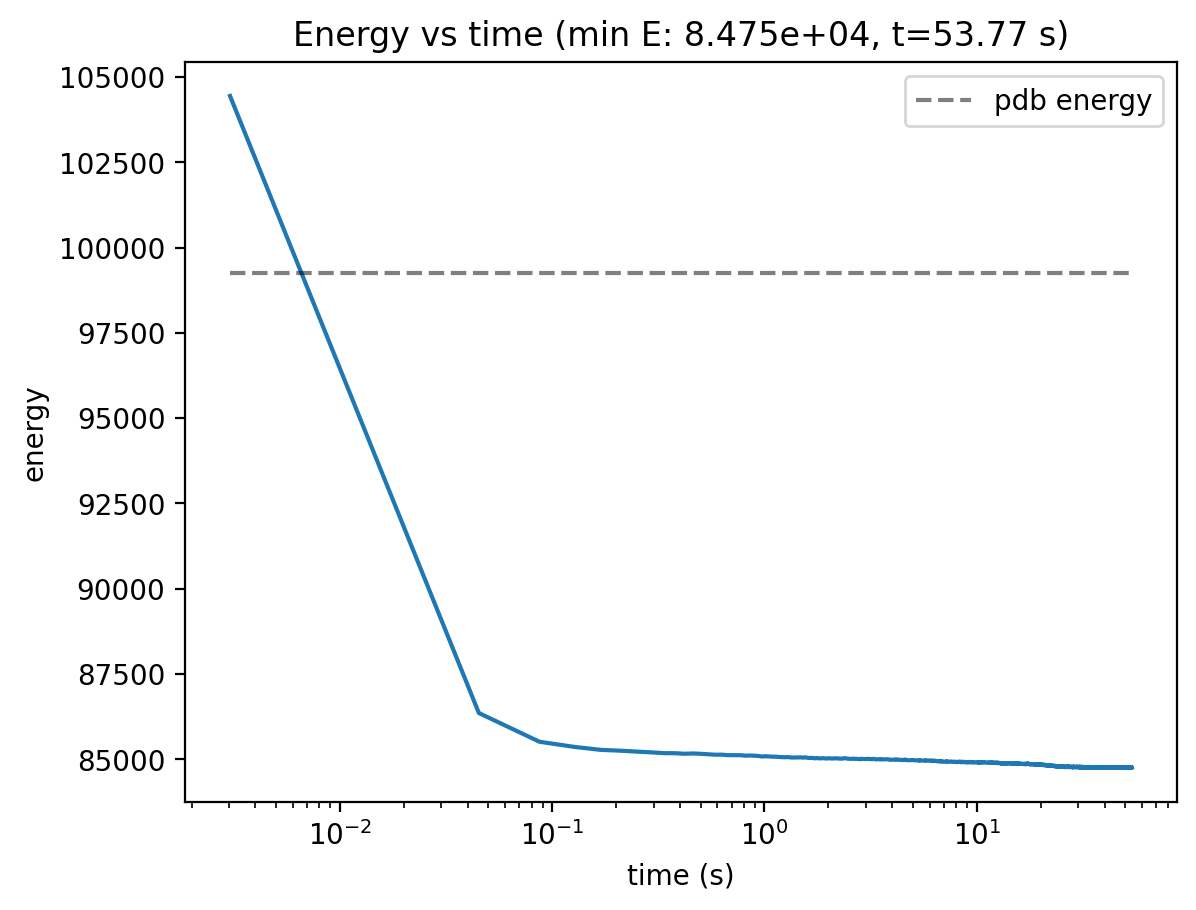

In [ ]:
energy_minimizer.plot_history()
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


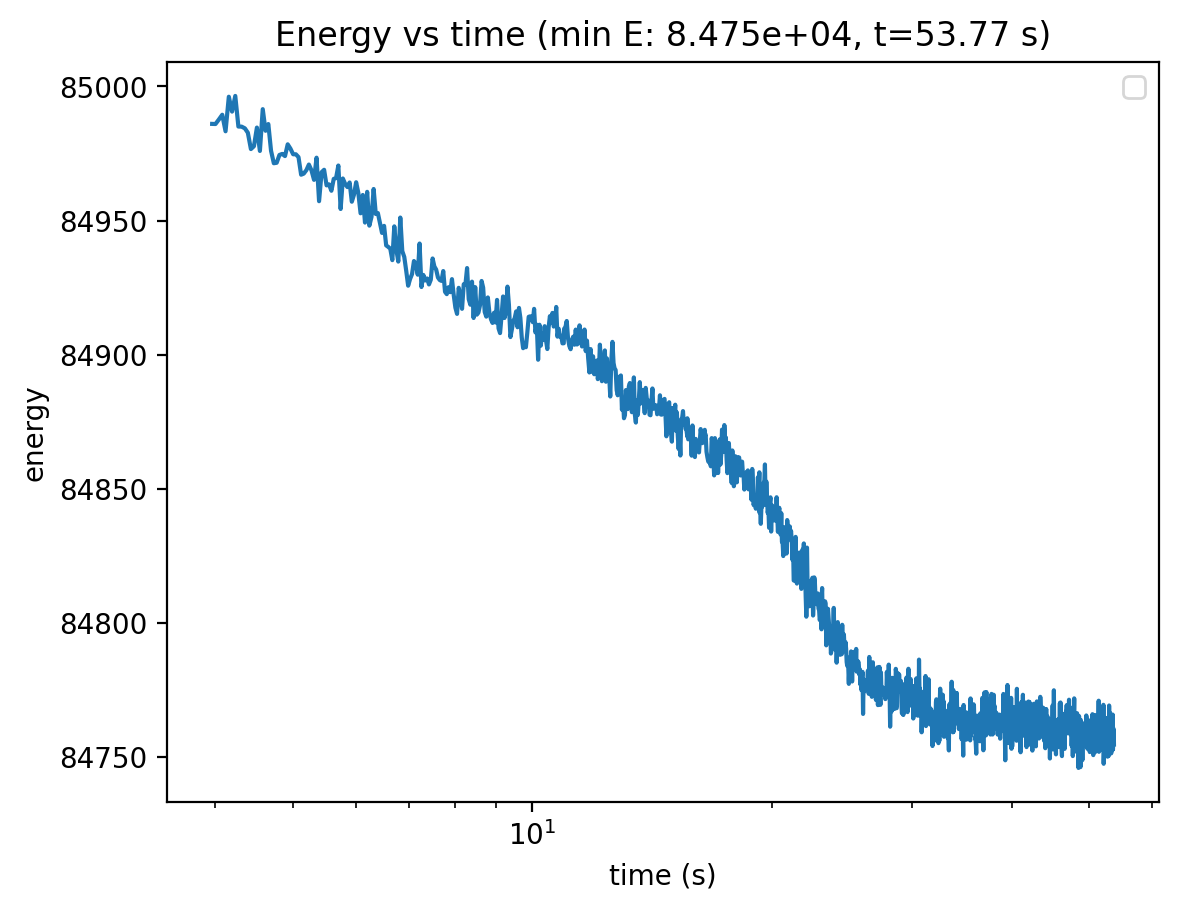

In [189]:
energy_minimizer.plot_history(100)
plt.yscale('linear')

plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot([h['time'][0],np.sum(h['time'])], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')

plt.legend()

In [215]:
N = 100
drop_rate = 40 #10
annealer = AnnealingLR(energy_minimizer.optimizer, 
                    lr_max=energy_minimizer.lr, 
                    lr_min=energy_minimizer.lr/drop_rate, 
                    epochs=N)


In [217]:
relax_counter = 10
for epoch in range(2*N):
    h = energy_minimizer.train(500)
    # also print the current lr
    if np.isnan(h['energy'][-1]):
        print('============Fail! nan')
        break
    c = energy_minimizer.early_stop.patience_counter
    print(f'epoch: {epoch}, energy: {h["energy"][-1]:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    annealer.step()
    print(f'FG lr: {annealer.get_last_lr()[0]:.2e}', end = '\r')

    if energy_minimizer.early_stopping_triggered:
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

Early stopping at step 460, time: 33.91 s, pat:11, FG lr: 1.06e-03
epoch: 36, energy: 84708.8, time: 34.82 s, pat:20, FG lr: 1.02e-03
relaxing 9
Early stopping at step 440time: 37.64 s, pat:14, FG lr: 9.15e-044
epoch: 40, energy: 84705.4, time: 38.51 s, pat:20, FG lr: 8.81e-04
relaxing 8
Early stopping at step 420, time: 43.22 s, pat:10, FG lr: 7.33e-04
epoch: 46, energy: 84702.7, time: 44.05 s, pat:20, FG lr: 7.06e-04
relaxing 7
Early stopping at step 440, time: 48.68 s, pat:12, FG lr: 5.87e-04
epoch: 52, energy: 84701, time: 49.52 s, pat:20, FG lr: 5.66e-04
relaxing 6
Early stopping at step 420, time: 51.39 s, pat:11, FG lr: 5.26e-04
epoch: 55, energy: 84700.3, time: 52.20 s, pat:20, FG lr: 5.07e-04
relaxing 5
Early stopping at step 420, time: 53.14 s, pat:15, FG lr: 4.89e-04
epoch: 57, energy: 84700, time: 53.96 s, pat:20, FG lr: 4.71e-04
relaxing 4
Early stopping at step 460
epoch: 58, energy: 84699.9, time: 54.85 s, pat:20, FG lr: 4.54e-04
relaxing 3
Early stopping at step 480, ti

In [218]:
h = energy_minimizer.train(20000)

Early stopping at step 400


Text(0.5, 1.0, 'Energy vs time (min E: 8.468e+04, t=91.64 s)')

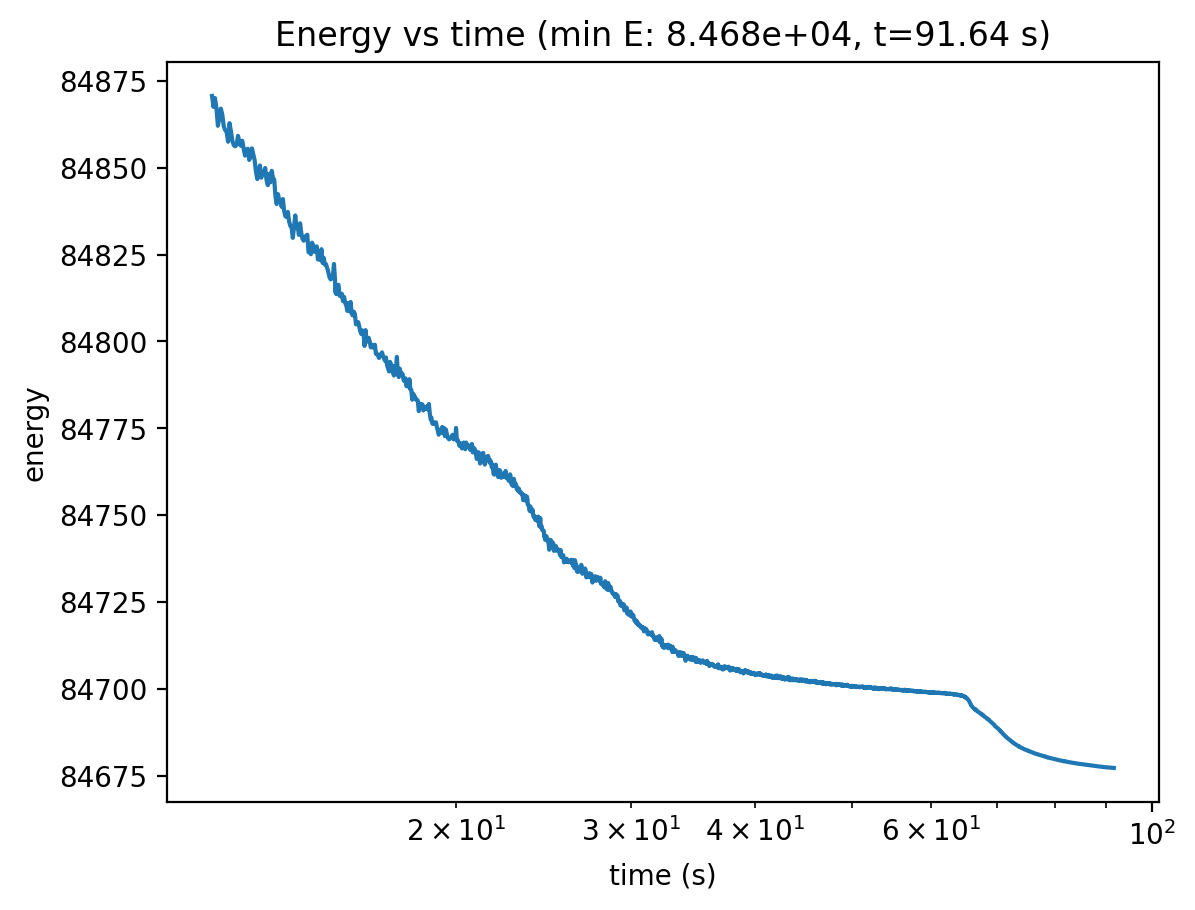

In [219]:
h = energy_minimizer.history
t = np.cumsum(h['time'])

k = 300

energy_minimizer.plot_history(k)


plt.yscale('linear')
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# plt.plot(t[[k,-1]], [pdb_energy, pdb_energy], 'k--', alpha =.5,  label = 'pdb energy')


In [220]:
xf = energy_minimizer.get_x()
xf.std(dim=0)

tensor([0.3500, 0.5247, 0.8164], device='cuda:0', grad_fn=<StdBackward0>)

In [221]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./PDB_refine-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller_no_solvent.topology, new_positions, open(pdb_test_file , 'w'))

In [222]:
import py3Dmol

p_ = py3Dmol.view(data=pf.get_file_text(pdb_test_file),width=400, height=300)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [223]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 8.520239871445408, 'CA': 6.72085005474156, 'backbone': 6.557702895609035}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [208]:
rmsd = pf.RMSD(pdb_unfolded_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 3.363873875777111, 'CA': 2.7518393688643585, 'backbone': 2.6716279826191003}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# GNN

In [11]:
energy = pf.EnergyProtein(prot, device = DEVICE)
pdb_energy = energy(prot.node_positions.to(DEVICE)).item()
# unfolded energy
# pdb_unfolded_energy = energy(pos_unfold.to(DEVICE)).item()

# f"{pdb_energy:.4g}, {pdb_unfolded_energy:.4g}"
# f"{pdb_energy:.4g}"

In [13]:
from coarsegrainer.GNN import GNNReparam

# hidden dimension
h = 100 #300
A = prot.adjacency_matrix.to(DEVICE) 
A += 0*energy.LJ_epsilon.to(DEVICE) + 0.2*torch.eye(len(A)).to(DEVICE)
# A = energy.LJ_epsilon.to(DEVICE)
# degree matrix
degs = torch.sum(A, dim=1)+1e-3
D_inv = torch.diag(1/degs)
# degree normalized adjacency matrix
# A =  D_inv**(1/2) @ A @ D_inv**(1/2) #+ 0.*torch.eye(len(A)).to(DEVICE)

n = len(A)
d = 3
init_scaling = .2 #.2 #6 #1.5
gnn_reparam = GNNReparam([h, h//1, h//1, d], A=A,
                        bias=True, 
                        initial_pos=prot.node_positions,
                        # activation=torch.nn.LeakyReLU() ,
                        activation=torch.nn.Tanh(), 
                        # output_init_sigma= init_scaling*init_radius, 
                        device=DEVICE, residual=True)


In [14]:
gnn_reparam._fit_history

{'loss': [3.9314136505126953,
  3.4541308879852295,
  3.04193377494812,
  2.6905431747436523,
  2.389589548110962,
  2.129420518875122,
  1.9023898839950562,
  1.7026269435882568,
  1.5255849361419678,
  1.3674486875534058,
  1.2251311540603638,
  1.096421718597412,
  0.9799598455429077,
  0.8748924136161804,
  0.780531644821167,
  0.6961211562156677,
  0.6207879185676575,
  0.5536174774169922,
  0.4937920570373535,
  0.4406890273094177,
  0.393730491399765,
  0.3522351384162903,
  0.31554114818573,
  0.28310146927833557,
  0.25438401103019714,
  0.22883319854736328,
  0.2060045748949051,
  0.18561775982379913,
  0.1674674153327942,
  0.15135937929153442,
  0.1370832473039627,
  0.12439687550067902,
  0.11305724829435349,
  0.10286704450845718,
  0.09368252009153366,
  0.08538012206554413,
  0.07783884555101395,
  0.07094616442918777,
  0.06460867822170258,
  0.05876569449901581,
  0.053391337394714355,
  0.0484687015414238,
  0.04396340996026993,
  0.03982916846871376,
  0.03603047505

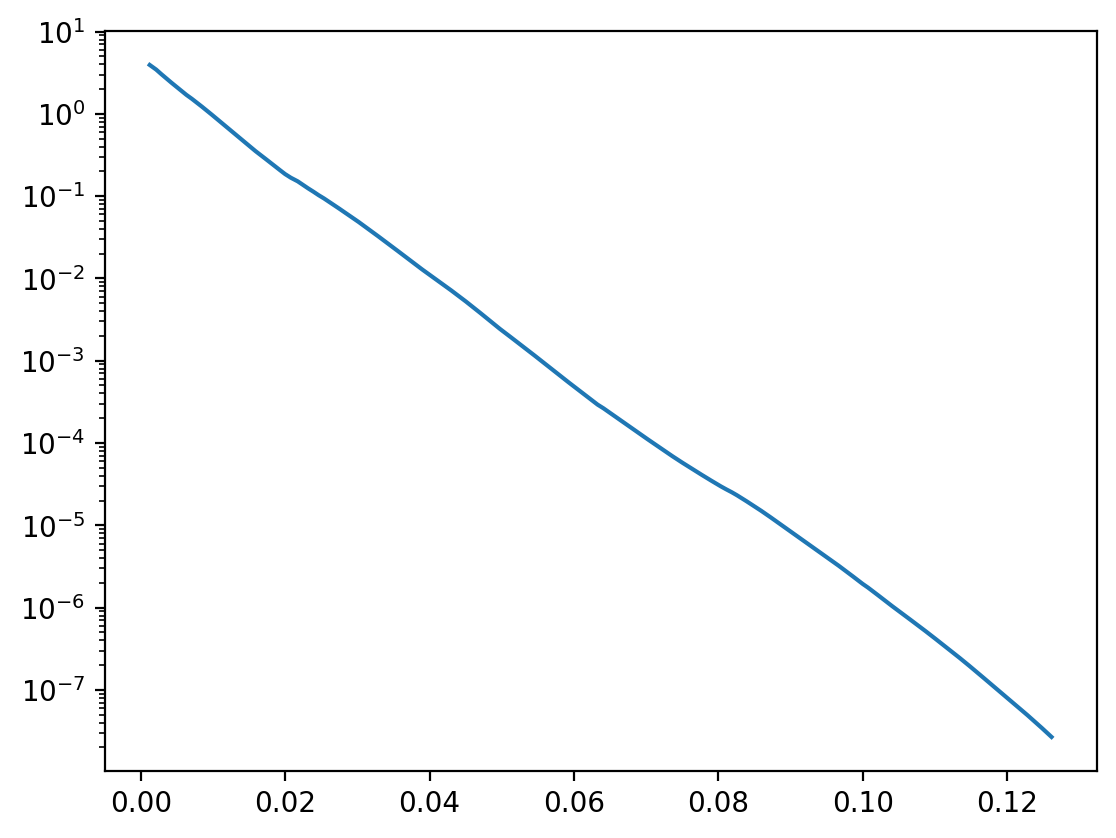

In [16]:
# plot fit history loss vs time 
plt.plot((gnn_reparam._fit_history['time']), gnn_reparam._fit_history['loss'])
plt.yscale('log')

In [12]:
x = gnn_reparam()

In [15]:
x_target = prot.node_positions.to(DEVICE)

In [16]:
# mse error between x_target and gnn_reparam output
mse = torch.nn.MSELoss()
mse(gnn_reparam(), x_target)

tensor(3.9533, device='cuda:0', grad_fn=<MseLossBackward0>)

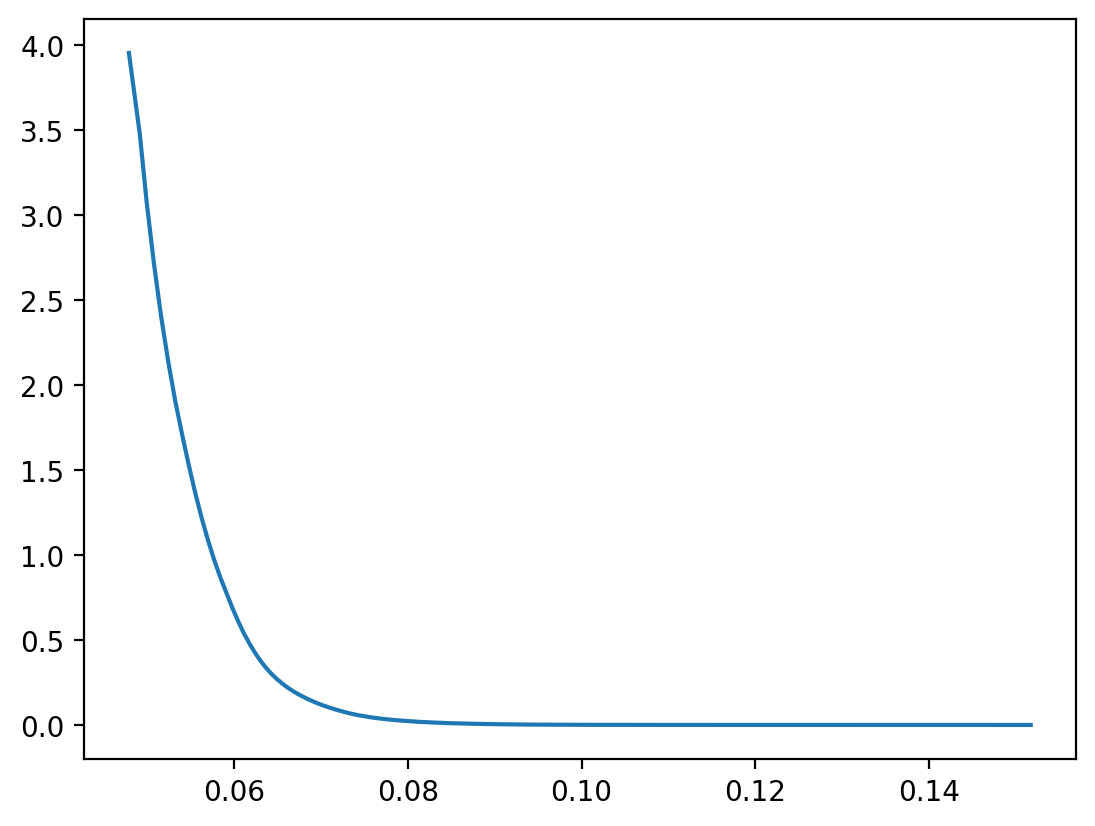

In [18]:
# plot the loss vs time
plt.plot(history['time'], history['loss'])

In [17]:

new_positions = V(gnn_reparam())*10

pdb_test_file = os.path.join(pdb_dir, f'./test_gnn-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [18]:
p_ = pf.pdb_3d_view(pdb_test_file)
p_.setStyle({'cartoon': {'color':'spectrum'}}); #'stick', 'cartoon'
# p_.setStyle({'stick': {}});
p_

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
cg.earlystopping.EarlyStopping

In [11]:
prot.non_bonded_data.keys()

dict_keys(['charge', 'sigma', 'epsilon'])

In [12]:
prot.node_label

['N',
 'C',
 'C',
 'O',
 'C',
 'C',
 'O',
 'O',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'C',
 'O',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'C',
 'C',
 'O',
 'N',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'C',
 'C',
 'C',
 'N',
 'C',
 'C',
 'C',
 'C',
 'C',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'C',
 'C',
 'C',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'C',
 'C',
 'C',
 'N',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'C',
 'C',
 'O',
 'O',
 'H',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O',
 'H',
 'H',
 'H',
 'N',
 'C',
 'C',
 'O'

In [8]:
prot.node_positions

tensor([[ 2.1464e+00,  6.5930e-01, -4.0770e-01],
        [ 2.2746e+00,  6.8210e-01, -3.3780e-01],
        [ 2.3653e+00,  5.6060e-01, -3.3630e-01],
        [ 2.3241e+00,  4.5250e-01, -2.9490e-01],
        [ 2.2484e+00,  7.3110e-01, -1.9540e-01],
        [ 2.2146e+00,  8.7880e-01, -2.0630e-01],
        [ 2.1166e+00,  9.0400e-01, -2.8000e-01],
        [ 2.2939e+00,  9.5980e-01, -1.5460e-01],
        [ 2.1615e+00,  6.3960e-01, -5.0550e-01],
        [ 2.0971e+00,  5.8260e-01, -3.6420e-01],
        [ 2.0915e+00,  7.4470e-01, -3.9720e-01],
        [ 2.3277e+00,  7.6190e-01, -3.8980e-01],
        [ 2.1647e+00,  6.7640e-01, -1.5140e-01],
        [ 2.3371e+00,  7.1650e-01, -1.3350e-01],
        [ 2.4908e+00,  5.8150e-01, -3.7700e-01],
        [ 2.5968e+00,  4.8210e-01, -3.6560e-01],
        [ 2.6308e+00,  4.5040e-01, -2.1880e-01],
        [ 2.6485e+00,  3.3360e-01, -1.8550e-01],
        [ 2.7190e+00,  5.3290e-01, -4.4300e-01],
        [ 2.5180e+00,  6.7260e-01, -4.1130e-01],
        [ 2.5629e+00

In [23]:
x_target
gnn_minimizer = GNNMinimizer(energy, x_target, gnn_reparam, optimizer_type='Adam',
    lr=LR*1e-1, lr_gnn=LR*2e-2,
    # lr=LR*5e-3, lr_gnn=LR*5e-3,
    # lr=4e-4, lr_gnn=1e-4,
    # lr=4e-3, lr_gnn=1e-4,
    # lr=1e-3, lr_gnn=1e-3,
    # lr=2*LR, lr_gnn=4e-3,
    clamp_grads=1e-2, log_step=20, log_pos_step=0, 
    log_dir='../results/logs', log_name=f'GNN_protein_{pdb_id}_',
    patience=PATIENCE, min_delta=MIN_DELTA*1e-0, 
    gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e0)


Using Adam optimizer
Log name: GNN_protein_2JOF_
Logging to: ../results/logs/GNN_protein_2JOF__n284_d3
Using Adam optimizer


In [24]:
(gnn_reparam().std(), gnn_minimizer.get_x().std())

(tensor(1.3905, device='cuda:0', grad_fn=<StdBackward0>),
 tensor(1.3905, device='cuda:0', grad_fn=<StdBackward0>))

In [27]:
N = 10
drop_rate = 50 #40 #10
annealer_gnn = AnnealingLR(gnn_minimizer.optimizer_gnn, 
                    lr_max=gnn_minimizer.lr_gnn, 
                    lr_min=gnn_minimizer.lr_gnn/drop_rate, 
                    epochs=N)

annealer_fg = AnnealingLR(gnn_minimizer.optimizer_fg, 
                    lr_max=gnn_minimizer.lr, 
                    lr_min=gnn_minimizer.lr/drop_rate, 
                    epochs=N)

In [28]:
# gnn_minimizer.min_delta /= 10

In [29]:
# annealer_fg.epochs = 200

In [30]:
# set the learning rate of optimizer_fg to 1e-3
# gnn_minimizer.optimizer_fg.param_groups[0]['lr'] = 1e-3  

In [35]:
relax_counter = 10
for epoch in range(2*N):
    h = gnn_minimizer.train(500)
    # also print the current lr
    
    c = gnn_minimizer.early_stop.patience_counter
    en = h["energy"][-1]
    if np.isnan(en):
        print('============Failed! Energy is nan============')
        break
    print(f'epoch: {epoch}, energy: {en:.6g}, time: {np.sum(h["time"]):.2f} s, pat:{c},',end=' ')
    
    if not gnn_minimizer.fine_grained:
        annealer_gnn.step()
        print(f'GNN lr: {annealer_gnn.get_last_lr()[0]:.2e}', end = '\r')
    else:
        annealer_fg.step()
        print(f'FG lr: {annealer_fg.get_last_lr()[0]:.2e}', end = '\r')
        
    if gnn_minimizer.early_stopping_triggered:
        
        print('\n')
        relax_counter -= 1
        print(f'\nrelaxing {relax_counter}', end = '\n')
        if relax_counter < 0 :
            break

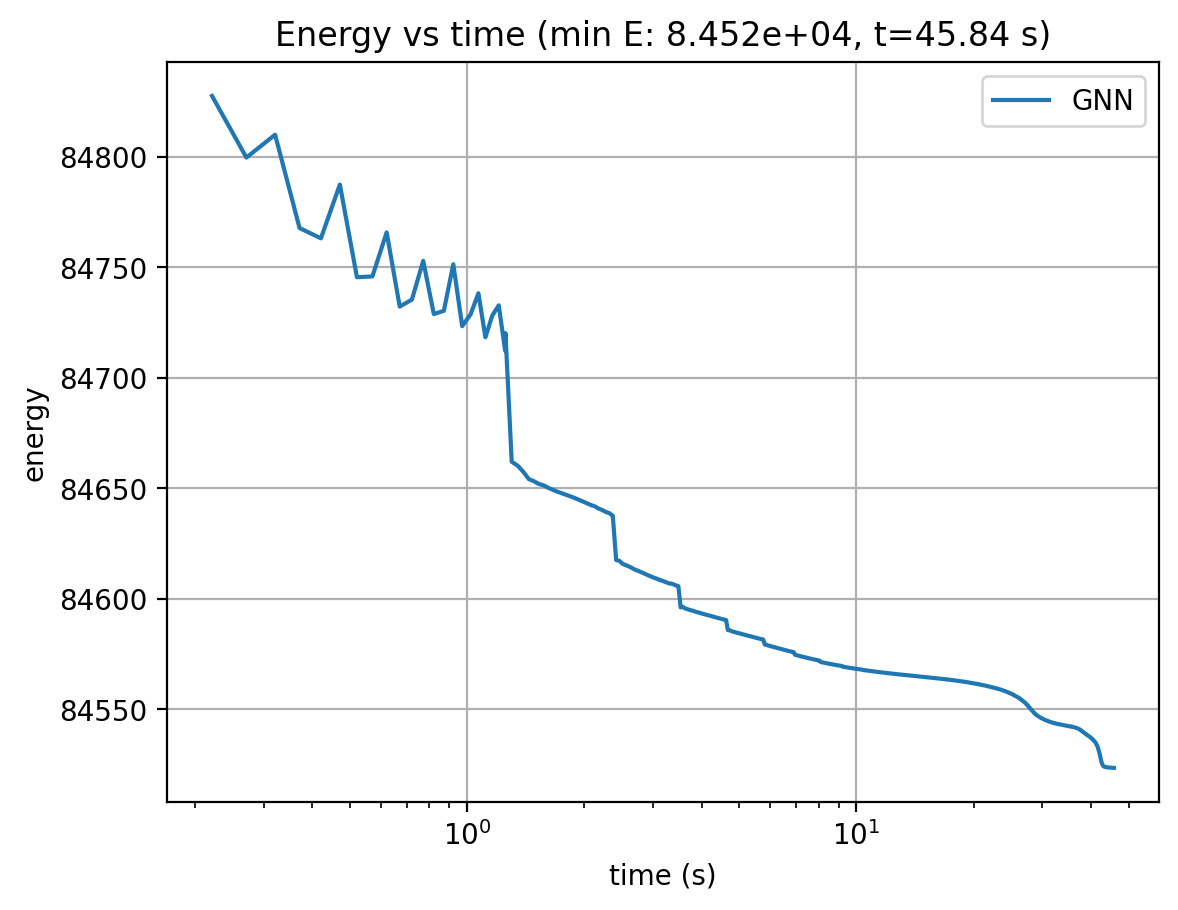

In [36]:
k = 3
gnn_minimizer.plot_history(start=k)
try:
    gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps+0)
except:
    pass
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.4g}, t={np.sum(h["time"]):.2f} s)')

# energy_minimizer.plot_history(k)
# plt.ylim(h['energy'][-1]-10, h['energy'][k]+1.0)
plt.yscale('linear')
plt.grid(True)
plt.legend(['GNN', 'FG', 'GD'])

### get X

In [37]:
xf = gnn_minimizer.get_x()
xf.std(dim=0)

tensor([0.4925, 0.4309, 0.3516], device='cuda:0', grad_fn=<StdBackward0>)

In [38]:
# Assuming you have new positions stored in a numpy array named new_positions
# Update the positions in the topology
# new_positions = layout.get_node_pos().detach().numpy()*10
new_positions = V(xf)*10

pdb_test_file = os.path.join(pdb_dir, f'./GNN-{pdb_id}.pdb')
app.PDBFile.writeFile(modeller.topology, new_positions, open(pdb_test_file , 'w'))

In [43]:
pf.pdb_3d_view(pdb_test_file)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### RMSD

In [48]:
rmsd = pf.RMSD(pdb_orig_file, pdb_test_file)
print(rmsd.RMSD)
view = rmsd.show_superimposed()


{'all': 1.4662993419092836, 'CA': 0.9476112430225921, 'backbone': 0.9119103586604344}
Showing all atoms superimposed structure


/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(
/home/nima/miniconda3/envs/cg-311/lib/python3.11/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 288
  warnings.warn(


3Dmol.js failed to load for some reason. Please check your browser console for error messages.